# MSTs vs SparseNets

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random as R
from graph.sparsenet import sparsenet

First, let's generate a graph.

In [2]:
G = nx.gnm_random_graph(200, 1000)

Now, let's get the minimum spanning tree.

In [3]:
mst = nx.minimum_spanning_tree(G)

How many nodes and edges are in it?

In [4]:
mst.number_of_nodes(), mst.number_of_edges()

(200, 199)

Now, let's calculate the SparseNet.

In [5]:
distance_matrix = nx.floyd_warshall_numpy(G)
vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
sn = nx.Graph()
colors = {}
for path in sparsenet(G, distance_matrix, vertex_to_index):
    color = (R.random(), R.random(), R.random())
    for node in path:
        if node not in colors:
            colors[node] = color
    for edge in zip(path, path[1:]):
        sn.add_edge(*edge)
sn.number_of_nodes(), sn.number_of_edges()

(200, 199)

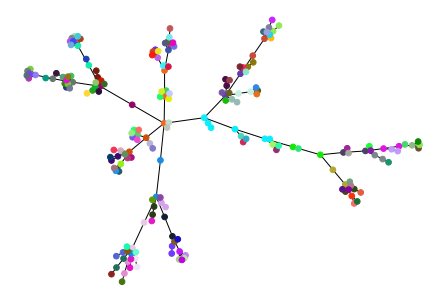

In [6]:
nx.draw(sn, pos=nx.spring_layout(sn, iterations=1000), node_size=32, node_color=[colors[node] for node in sn.nodes()])

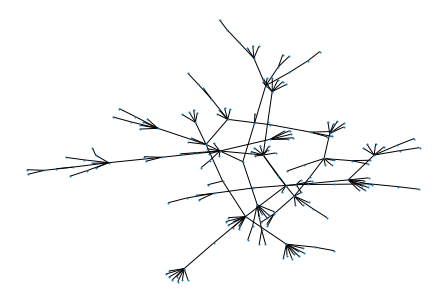

In [7]:
nx.draw(mst, node_size=1)

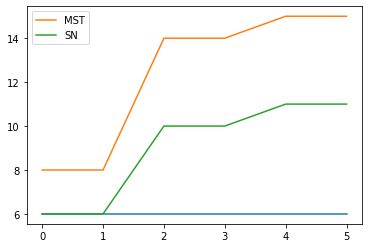

In [8]:
diameter = distance_matrix.max()
lengths = []
for i, distances in enumerate(np.array(distance_matrix)):
    for j, distance in enumerate(distances):
        if distance == diameter:
            try:
                lengths.append((len(nx.shortest_path(G, i, j)), 
                                len(nx.shortest_path(mst, i, j)),
                                len(nx.shortest_path(sn, i, j))))
            except:
                pass
lengths_G, lengths_MST, lengths_SN = list(zip(*lengths))
plt.plot(sorted(lengths_G))
plt.plot(sorted(lengths_MST), label='MST')
plt.plot(sorted(lengths_SN), label='SN')
plt.legend();

Let's repeatedly run the MST and SparseNet algorithms on the same graph and see the outputs.

In [9]:
for n_trial in range(3):
    G = nx.gnm_random_graph(200, 1000)
    G = G.subgraph(next(nx.connected_components(G)))
    distance_matrix = nx.floyd_warshall_numpy(G)
    vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
    mst = nx.minimum_spanning_tree(G)
    sn = nx.Graph()
    for path in sparsenet(G, distance_matrix, vertex_to_index):
        for edge in zip(path, path[1:]):
            sn.add_edge(*edge)

    diameter = distance_matrix.max()
    lengths = []
    for i, distances in enumerate(np.array(distance_matrix)):
        for j, distance in enumerate(distances):
            if distance == diameter:
                try:
                    lengths.append((len(nx.shortest_path(mst, i, j)),
                                    len(nx.shortest_path(sn, i, j))))
                except:
                    pass
    lengths_MST, lengths_SN = list(zip(*lengths))
    plt.plot(sorted(lengths_MST), label='MST')
    plt.plot(sorted(lengths_SN), label='SN')
    plt.legend()
#     plt.savefig('plots/trial-%s.png'%n_trial)
    plt.clf();

<Figure size 432x288 with 0 Axes>

In [44]:
from multiprocessing import Pool, cpu_count

def diff(v, e):
    G = nx.gnm_random_graph(v, e)
    G = G.subgraph(next(nx.connected_components(G)))
    distance_matrix = np.array(nx.floyd_warshall_numpy(G))
    vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
    mst = nx.minimum_spanning_tree(G)
    sn = nx.Graph()
    for path in sparsenet(G, distance_matrix, vertex_to_index):
        for edge in zip(path, path[1:]):
            sn.add_edge(*edge)

    lengths = []
    diameter = distance_matrix.max()
    for i, distances in enumerate(np.array(distance_matrix)):
        for j, distance in enumerate(distances):
            if distance == diameter:
                try:
                    lengths.append((len(nx.shortest_path(mst, i, j)),
                                   len(nx.shortest_path(sn, i, j))))
                except:
                    pass
    lengths_MST, lengths_SN = list(zip(*lengths))
    return G.number_of_nodes(), G.number_of_edges(), sum(np.array(lengths_SN)) - sum(np.array(lengths_MST))

with Pool(cpu_count()) as pool:
    args = []
    for _ in range(cpu_count()):
        v = 200
        e = 1000
        args.append((v, e))
    differences = pool.starmap(diff, args)

In [54]:
from multiprocessing import Pool, cpu_count

def stats(v, e):
    G = nx.gnm_random_graph(v, e)
    G = G.subgraph(next(nx.connected_components(G)))
    distance_matrix = np.array(nx.floyd_warshall_numpy(G))
    vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
    mst = nx.minimum_spanning_tree(G)
    sn = nx.Graph()
    for path in sparsenet(G, distance_matrix, vertex_to_index):
        for edge in zip(path, path[1:]):
            sn.add_edge(*edge)

    sn_dm = np.array(nx.floyd_warshall_numpy(sn))
    mst_dm = np.array(nx.floyd_warshall_numpy(mst))
    return (np.median(sn_dm), sn_dm.mean(), sn_dm.max()), \
           (np.median(mst_dm), mst_dm.mean(), mst_dm.max())

with Pool(cpu_count()) as pool:
    args = []
    for _ in range(cpu_count()):
        v = 200
        e = 1000
        args.append((v, e))
    statistics = pool.starmap(stats, args)

In [59]:
np.mean([dm_stats for sn_stats, dm_stats in statistics], axis=0)

array([ 7.8375    ,  7.89613201, 18.2125    ])